# Bodyfat Calculator

Group 7 member: Hongyi Jin, Wanwan Su, Yingjing Jiang

## 1.Introduction
Body fat percentage is an excellent reference for people to assess the health condition. However, accurate measurement of body fat is not economical (or convenient) as weight and height. In this module, we are going to figure out a simple and robust model to measure percentage of body fat.

## 2.Background Information
The data is a real collection of 252 men with measurements of their Bodyfat Percentage, Body Density and other 14 body measurements, including Age, Weight, Height, Adioposity(BMI), circumference of Chest, Abdomen, Hip, Thigh, Knee, Ankle, Biceps, Forearm and Wrist.  
By looking at other online bodyfat calculators and some articles, we find that weight and waist is most frequent used to calculate bodyfat. Waist is actually abdomen variable here, so we think that an useful calculator is most likely to include weight and abdomen.

## 3.Data Processing  
### 3.1 Data Overview

In [2]:
library(car); library(leaps); library(faraway); library(glmnet); library(repr); library(dplyr); library(ggplot2)
bf <- read.csv('BodyFat.csv', header = TRUE)[ , -1]; names(bf) <- tolower(names(bf))

We first check the distribution of each variables in the data. Most variables distribute normally. However, several variables have some outliers faraway from other data points. We find that **patient 39** has an extrmely large weight, as well as body figures. And **patient 182** has 0 bodyfat with small body figures. We consider these two patients as potential outliers in the data.

### 3.2 Verify Data
#### Bodyfat

According to Siri's equation $Body fat = \frac{495}{Density} - 450$, we can compute bodyfat with density. When we compare all the given bodyfat and calculated bodyfat, we find that several observations are quite different, but they actually are normal.   
The **patient 182** has a 0 bodyfat in the data and -3% calculated bodyfat. Based on the fact this patient has relatively smaller body figure than other people, the data of this patient may have some error or the patient is in some special condition. Thus, this patient is not suitable for the model we are going to build. We exclude this point in the data.  
Then we delete the density variable in the data, as this very hard to be obtained by people themselves and impossible to use in the calculator.  

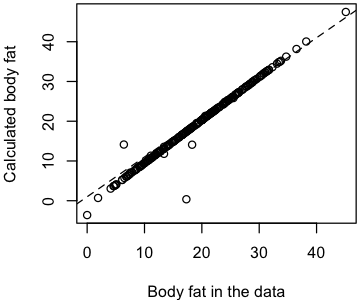

In [3]:
bdfat <- 495/bf$density - 450; options(repr.plot.width=3, repr.plot.height=2.5); par(mar = c(4, 4, 0.2, 0.2), cex = 0.8)
plot(bf$bodyfat, bdfat, xlab = 'Body fat in the data', ylab = 'Calculated body fat');abline(1,1, lty = 2)

#### Adiposity(BMI)
The adiposity is calculated by the weight and height. By simillar process like above, we find **patient 42** has wrong height data. We replace the height of **patient 42** with the height calculated by his weight and adiposity. After this, the value of this patient is reasonable. The relatively small data size is also one reason that we keep this patient rather than delete him.

In [4]:
bmi <-  (bf$weight*0.454)/(bf$height*2.54/100)^2; sp_point1 <- which(abs(bmi - bf$adiposity) > 5)
sp_data1 <- cbind(bf[sp_point1 , 1:6], bmi = bmi[sp_point1], bf[sp_point1, 7:16]); sp_data1
bf[42, ]$height <- round(sqrt((bf[42, ]$weight*0.454)/bf[42, ]$adiposity)*100/2.54, 2); bf <- bf[ , -2]

,bodyfat,density,age,weight,height,adiposity,bmi,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
42,31.7,1.025,44,205,29.5,29.9,165.7671,36.6,106,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


### 3.3 Diagnose Data

We then build a linear model to check the outliers. We can see that **patient 39, 86, 221** have very large cook's distance than other points. **Patient 39** has extremly large weight. Sinece our model is build for ordinal condition, we decide to delete this point. **Patient 86** and **Patient 221** have some abnormal figures as well, but they are not too extreme. Thus we keep the two points in the data.

To summarize, we exclued **patient 39, 182** in our model.

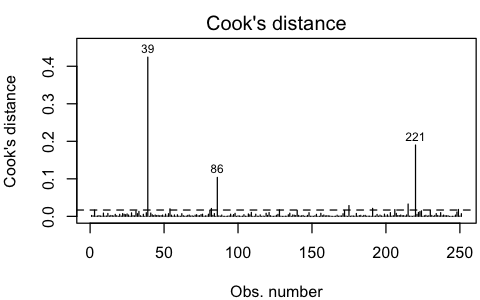

In [5]:
fit1 <- lm(bodyfat ~ ., data = bf[-182, ]); options(repr.plot.width=4, repr.plot.height=2.5); par(mar = c(4, 4, 2, 0.2), cex = 0.8)
plot(fit1, which = 4);abline(h = 4/(nrow(bf) - ncol(bf)), lty = 2)

## 4.Variable Selection  
### 4.1 Stepwise selection

We first check the p-value of each variable in the full model, and find that many variables are not significant. In order to get a simple model, we first use stepwise method with AIC and BIC criteria to select variables.  
We write a function to perform backward and forward selection with AIC and BIC creitera on certain data.

In [6]:
regModel <- function(bf_data){
  fit2 <- lm(bodyfat ~ ., data = bf_data); fit2_AIC <- step(fit2, k = 2, direction = 'backward', trace = F)
  fit2_BIC <- step(fit2, k = log(nrow(bf_data)), direction = 'backward', trace = F); fit_base <- lm(bodyfat ~ 1, data =  bf_data)
  base_AIC <- step(fit_base, scope = list(lower = ~ 1, upper = fit2), direction = 'forward', trace = F)
  base_BIC <- step(fit_base, scope = list(lower = ~ 1, upper = fit2), k = log(nrow(bf_data)), direction = 'forward', trace = F) 
  result <- list(); result[['fit']] = fit2; result[['back_AIC']] = fit2_AIC; result[['back_BIC']] = fit2_BIC
  result[['for_AIC']] = base_AIC; result[['for_BIC']] = base_BIC; return(result)}
bf_data <- bf[c(-39, -182), ]; reg_with_bmi <- regModel(bf_data)

We find that the forward selection with BIC gives the simplest model and doesn't lose robustness shown by R square. Considering the fact that the adiposity is selected in backward selection and accordinng to some research that BMI can be highly related to bodyfat, we split adiposity into the square of weight and the inverse of height to see which part of BMI contributes. We get a different model using forward selection model with BIC.

In [7]:
bf_new <- bf[c(-39, -182), -5]; bf_new$w.sqr <- bf_new$weight ^ 2/10000; bf_new$h.inv <- 1/bf_new$height; reg_without_bmi <- regModel(bf_new)

### 4.3 Mallow's cp

For Mallow's Cp method, we select the subsets with minimum Cp values within different variable number $p$($p<k$, $k$ predictors in all) first. Then, we compare those Cp values with $p+1$ to get the best subset.

In [8]:
X=model.matrix(lm(bodyfat~., data=bf_new))[,-1]; g=leaps(X,bf_new$bodyfat,nbest=1); 

According to the Cpplot figure, we can find that the model with predictor 1, 2, 3, 6, 13 and 14 is very close to the line($Cp=p+1$), and doesn't have too many predictors. We think it is the best choice for us.

In [9]:
cp.choice=c(2,3,4,7,14,15); fit.cp=lm(bodyfat~.,data=bf_data[ ,c(1,cp.choice)])

### 4.4 LASSO
Using the method of cross validation, we can get best lambda $\lambda=0.4621$. With the lambda, we can get selected variables age, height, abdomen and wrist.

In [10]:
set.seed(0202); fit_lasso <- cv.glmnet(as.matrix(bf_new[,-1]),bf_new$bodyfat,family = "gaussian", type.measure = "deviance")
fit.lasso <- glmnet(as.matrix(bf_new[,-1]),bf_new$bodyfat,family = "gaussian", lambda = fit_lasso$lambda.1se, alpha = 1)
bodyfat_pre <- predict(fit.lasso, newx = as.matrix(bf_new[,-1]))
mse.lasso <- mean((bodyfat_pre-bf_new$bodyfat)^2); coef.l <- as.data.frame(t(as.matrix(coef(fit.lasso))));

### 4.5 Cross validation
Finally, we perform 10-fold cross validation to compute and compare MSE of models with variable combination and determine which one to use. The Mallow's cp model has too many variables and lasso model's MSE is relatively large. Thus we choose the model with square of weight.

In [11]:
out <- data.frame(bind_rows(coef(reg_with_bmi[[5]]), coef(reg_without_bmi[[5]]), coef(fit.cp), coef.l[,coef.l != 0]))
row.names(out) <- c('for_BIC', 'for_BIC_sqr', 'Mallow_cp', 'Lasso'); out
cvReg <- function(data, model){ set.seed(0202); index <- sample(1:10, nrow(bf_data), replace = T); mse <- c()
  for(i in 1:10){train.ind <- index[index == i]; train_data <- data[train.ind, ]; test_data <- data[-train.ind, ]
    fit <- lm(model, data = data); out <- mean((predict(fit, newdata = test_data) - test_data$bodyfat)^2); mse <- c(mse, out)}
  return(mean(mse))}
data.frame(full = cvReg(bf_data, bodyfat ~ .),for_bic = cvReg(bf_data, bodyfat ~ abdomen + weight + wrist), for_bic_sqr = cvReg(bf_new, bodyfat ~ abdomen + wrist + w.sqr),
          m_cp = cvReg(bf_data, fit.cp$call$formula), lasso = mse.lasso)

,X.Intercept.,abdomen,weight,wrist,w.sqr,age,height,chest,forearm
for_BIC,-23.413680,0.8859052,-0.08542707,-1.3317527,NA,NA,NA,NA,NA
for_BIC_sqr,-32.222701,0.8977107,NA,-1.3005148,-2.486392,NA,NA,NA,NA
Mallow_cp,84.054497,NA,0.29315181,-2.9395395,NA,0.17534915,-1.0368668,0.03331354,-0.07551254
Lasso,-9.264031,0.6095811,NA,-0.5569436,NA,0.01607803,-0.2658943,NA,NA


full,for_bic,for_bic_sqr,m_cp,lasso
14.52131,15.59827,15.38895,14.52131,16.53083


## 5.Model Diagnose and Interpretation

Then we check the robustness of the selected model. By residual plot, we can see it has constant variance and the linear relationship is satisfied. By QQ-plot, the normality assumption is also satisfied.   
Another major concern is the multicollinearity. It is reasonable to guess that your body figures are all somehow related. We check the VIF of final model and all of them are below 5. It shows the model has no or little multicollinearity.  
The coefficient of final model is shown in the table, and the model has 0.7318 adjusted R square, which is quite good since there are just 3 predictors. The p-value of the model is $< 2.2 \times 10{−16}$, which also shows that the model is good.

X.Intercept.,abdomen,w.sqr,wrist
-32.2227,0.8977,-2.4864,-1.3005


,abdomen,w.sqr,wrist
vif.fit_BIC.,4.06109,5.286273,2.00094


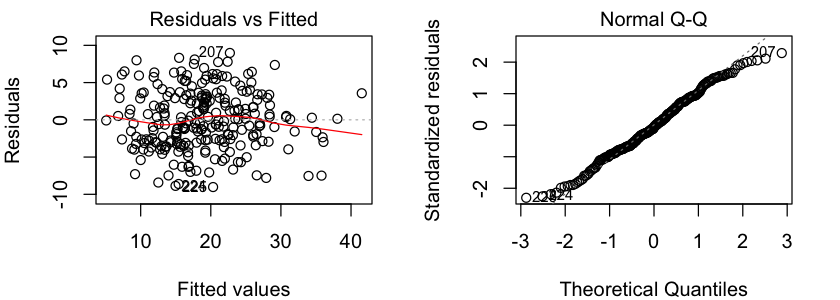

In [12]:
fit_BIC <- lm(bodyfat ~ abdomen + w.sqr + wrist, data = bf_new); data.frame(t(round(coef(fit_BIC), 4))); options(repr.plot.width=7, repr.plot.height=2.5)
par(cex = 0.5, mar = c(4,4,1.5,2)); layout(matrix(1:2, ncol = 2)); plot(fit_BIC, which = c(1,2)) 
t(data.frame(vif(fit_BIC)))

## 6.Laymen’s Interpretation
Our final model would be $$Body fat = -32.22 + 0.90 \times abdomen - 2.49 \times (\frac{weight}{100})^{2} - 1.30 \times wrist$$

This model means that when other variables are fixed, the larger the waist is, the more the bodyfat is; the larger the weight or wrist circumference are, the less the bodyfat is. The sign of weight and wrist can be easily explained. When others are fixed, if weight increases, it means that the density of muscle also increases and the people is stronger, which leads to lower bodyfat. That is the same for wrist.

## 7.Strengths and Weakness 
**Strength**  
1. Use different methods to obtain a simple model respectively and choose the best one
2. Achieve an adjusted R square of 0.735 with only 3 predictors
3. The model is quite simple, which is easy to understand and use

**Weakness**
1. The size of the dataset is small
2. It is possible to find a better model with some other transformation of variables or other kinds of models

## 8.Conclusion
We use stepwise selection, mallow'cp and lasso to get several simple models and pick the best one as our final model. The model we obtained is valid and can produce accurate prediction.

## 9.Contribution


Wanwan Su: Summarying and cleaning raw data, corresponding part of jupyter notebook writing, materical collection.  
Hongyi Jin: Variable selections, corresponding part of jupyter notebook writing, organization of al the jupyter notebook contents.  
Yingjing Jiang: Model diagnosis and interpretation, corresponding part of jupyter notebook writing, revising the final summary contents.

## Reference
[1] Flegal, K. M. , Shepherd, J. A. , Looker, A. C. , Graubard, B. I. , Borrud, L. G. , & Ogden, C. L. , et al. (2009). Comparisons of percentage body fat, body mass index, waist circumference, and waist-stature ratio in adults. American Journal of Clinical Nutrition, 89(2), 500.

[2] Online bodyfat calculators: https://www.active.com/fitness/calculators/bodyfat; https://www.calculator.net/body-fat-calculator.html; http://www.bmi-calculator.net/body-fat-calculator/